In [2]:
import importlib
from ipynb.fs.full.slackbot import ping_slack
import pandas as pd
import xgboost as xgb
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import BSpline, make_interp_spline, interp1d
#import rpy2.robjects as robjects
#from rpy2.robjects.packages import importr
import csv
from dfply import *
from xgboost import XGBClassifier
import itertools
import os
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from os.path import exists
import logging
import time

import utils_function

In [3]:
importlib.reload(utils_function)

<module 'utils_function' from '/home/hoyinchan/code/AKI_CDM_PY/utils_function.py'>

In [5]:
site_list = ['KUMC', 'UTSW', 'MCW', 'UofU', 'UIOWA', 'UMHC', 'UPITT', 'UTHSCSA', 'UNMC']

In [6]:
site='KUMC'
year=2014

In [7]:
def cohort_table_2(site):

    configs_variables = utils_function.read_config(site)
    datafolder = configs_variables['datafolder']
    home_directory = configs_variables['home_directory']  
    
    onset = pd.read_parquet(datafolder+site+'/p0_onset_'+site+'.parquet')        

    def count_AKI(onset, new_name, cohort_table=None):
        cohort_table2 = onset[['ENCOUNTERID', 'AKI_STAGE']].groupby('AKI_STAGE').count()
        cohort_table2.rename(columns={'ENCOUNTERID': new_name}, inplace=True)
        # Add a row for the total of stages 1.0, 2.0, and 3.0
        total = cohort_table2.loc[1.0:3.0].sum()
        cohort_table2.loc['Total_AKI'] = total  
        cohort_table2.loc['Total'] = onset.shape[0]
        if cohort_table is not None:
            cohort_table2 = pd.concat([cohort_table, cohort_table2], axis=1)
        return cohort_table2

    cohort_table = count_AKI(onset, 'Raw_count')

    onset= onset[onset['SINCE_ADMIT']!=0]
    cohort_table2 = count_AKI(onset, 'drop_first_day_encounter', cohort_table)

    covid = pd.read_parquet(datafolder+site+f"/p0_covid_status_{site}.parquet")
    covid = covid.drop_duplicates()
    covid_false = covid[covid['BCCOVID']]
    onset = onset.merge(covid_false, on = ['PATID','ENCOUNTERID'],how='inner')
    cohort_table3 = count_AKI(onset, 'drop_covid', cohort_table2)

    data = pd.read_pickle(datafolder+site+'/bt3pos'+''+'_'+site+'_'+'stg01'+'_'+str(3000)+'.pkl')
    cohort_table3.loc['Total_AKI', 'FLAG_sum'] = data['FLAG'].sum()
    # Add the total of data[data['FLAG'] == 0]['FLAG'].sum() to row 0.0
    cohort_table3.loc[0.0, 'FLAG_sum'] = (data['FLAG'] == 0).sum()
    cohort_table3.loc['Total', 'FLAG_sum'] = data.shape[0]
    
    stg = configs_variables['stg']
    fs = configs_variables['fs']
    oversample = configs_variables['oversample']
    model_type = configs_variables['model_type']
    drop_correlation_catboost = configs_variables['drop_correlation_catboost']
    if drop_correlation_catboost:
        suffix='nc'
    else:
        suffix= ''
    y_train = pd.read_pickle(datafolder+site+'/y_train_'+site+'_'+str(3000)+'_'+stg+'_'+fs+'_'+oversample+suffix+'.pkl')
    y_test =  pd.read_pickle(datafolder+site+ '/y_test_'+site+'_'+str(3000)+'_'+stg+'_'+fs+'_'+oversample+suffix+'.pkl')
    
    cohort_table3.loc['Total_AKI', 'y_train'] = y_train.sum()
    # Add the total of data[data['FLAG'] == 0]['FLAG'].sum() to row 0.0
    cohort_table3.loc[0.0, 'y_train'] = (y_train == 0).sum()
    cohort_table3.loc['Total', 'y_train'] = y_train.shape[0]
        
    cohort_table3.loc['Total_AKI', 'y_test'] = y_test.sum()
    # Add the total of data[data['FLAG'] == 0]['FLAG'].sum() to row 0.0
    cohort_table3.loc[0.0, 'y_test'] = (y_test == 0).sum()
    cohort_table3.loc['Total', 'y_test'] = y_test.shape[0]
        
    
    return cohort_table3

In [269]:
pkls[0]

'/blue/yonghui.wu/hoyinchan/Data/data2022/UofU/dx00.pkl'

In [9]:
import pandas as pd
import os
import re
pkl_files = ["/blue/yonghui.wu/hoyinchan/Data/data2022/UofU/dx00.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UofU/cohort_table00.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2037.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2031.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_2033.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2035.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2030.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_2030.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2036.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/dx_UMHC_2034.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_2036.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2031.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/dx_UMHC_2035.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2032.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2037.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_2035.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_1989.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_2037.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2034.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2034.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2036.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2033.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2033.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_2031.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_1989.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_2032.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2035.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_2034.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/cohort_table00.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2032.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_1989.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/KUMC/cohort_table00.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UIOWA/cohort_table00.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UTSW/cohort_table00.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/meltcorrallcount_0.8.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/MCW/demo_MCW_2011.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/MCW/labcat_MCW_2011.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/MCW/onset_MCW_2011.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/MCW/px_MCW_2011.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/MCW/dx_MCW_2011.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/MCW/vital_MCW_2011.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/MCW/amed_MCW_2011.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/MCW/cohort_table00.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UNMC/cohort_table00.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UPITT/labcat_UPITT_2012.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UPITT/amed_UPITT_2009.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UPITT/labnum_UPITT_2012.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UPITT/onset_UPITT_2012.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UPITT/amed_UPITT_2012.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UPITT/vital_UPITT_2009.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UPITT/vital_UPITT_2012.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UPITT/cohort_table00.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UPITT/demo_UPITT_2012.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UTHSCSA/amed_UTHSCSA_2009.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UTHSCSA/df_rrt00.pkl","/blue/yonghui.wu/hoyinchan/Data/data2022/UTHSCSA/cohort_table00.pkl"]

In [16]:
match = re.search(r'/data(\d+)/([^/]+)/', pkl_files[2])
match.group(1)
match.group(2)

'UMHC'

In [32]:
datafolder = '/blue/yonghui.wu/hoyinchan/Data/data2022/'

for file in pkl_files:
    # Extract site and year using regex
    match = re.search(r'[a-z]+_([A-Z]+)_(\d+)\.pkl', file)   
    if match:
        year = match.group(1)
        site = match.group(2)
        print(file, year, site)
        
        try:
            # Read the original pickle file
            df = pd.read_pickle(file)
            
            # Define the output file path
            output_folder = os.path.join(datafolder, year)
            output_file = os.path.join(output_folder, f'onset_{year}_{site}.pkl')
            
            
            # Create the output folder if it doesn't exist
#            os.makedirs(output_folder, exist_ok=True)
            df2 = pd.read_pickle(output_file)
            # Save the DataFrame to the new file
#            df.to_pickle(output_file)
            
            # Output the shape
            print(f'{file}:{df.shape} -> {output_file}:{df2.shape}')
        except Exception as e:
            print(f'{file}: Failed to process ({e})')
    else:
        print(f'{file}: Failed to extract site and year')

/blue/yonghui.wu/hoyinchan/Data/data2022/UofU/dx00.pkl: Failed to extract site and year
/blue/yonghui.wu/hoyinchan/Data/data2022/UofU/cohort_table00.pkl: Failed to extract site and year
/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2037.pkl UMHC 2037
/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2037.pkl:(4, 6) -> /blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2037.pkl:(4, 4)
/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2031.pkl UMHC 2031
/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2031.pkl:(45, 6) -> /blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2031.pkl:(45, 4)
/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_2033.pkl UMHC 2033
/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/demo_UMHC_2033.pkl:(20, 11) -> /blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/onset_UMHC_2033.pkl:(20, 4)
/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_2035.pkl UMHC 2035
/blue/yonghui.wu/hoyinchan/Data/data2022/UMHC/vital_UMHC_203

In [11]:
onset = pd.read_parquet(datafolder+site+'/p0_onset_'+site+'.parquet')

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

## Create Flow Chart for baseline estimation

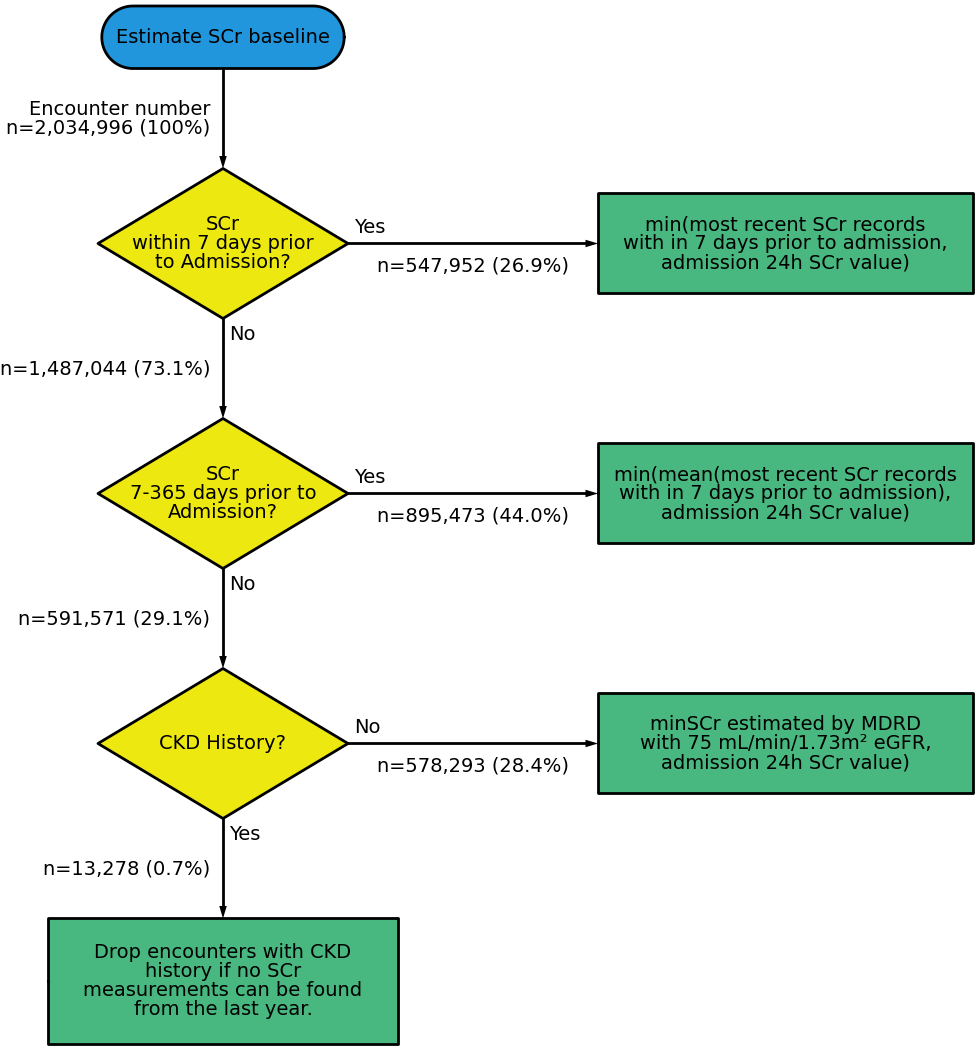

In [5]:
flow_chart_dict = {'Total Encounters': 2034996,
 'Total Patients': 1121851,
 'Enc. with 1w SCr': 547952,
 'Enc. without 1w SCr': 1487044,
 'Enc. with 1y SCr': 895473,
 'Enc. without 1y SCr': 591571,
 'Non-CKD Enc. without 1y SCr': 578293,
 'CKD Enc. without 1y SCr': 13278,
 'Total Onset Enc.:': 414622,
 'Total Onset Patients:': 315950,
 'AKI1 Enc.': 270999,
 'AKI2 Enc.': 88052,
 'AKI3 Enc.': 55571}

total_encounters = flow_chart_dict['Total Encounters']
percentage_dict = {
    key: np.round((value / total_encounters * 100),1) if isinstance(value, (int, float)) else value
    for key, value in flow_chart_dict.items()
}
percentage_dict['Total Encounters']=100

import schemdraw
from schemdraw import flow

arl = 2
with schemdraw.Drawing() as d:
    d.config(fontsize=14, unit=0.5)
    # Start terminal
    d += flow.Terminal().label('Estimate SCr baseline').fill('#2296dd')
    # Arrow to decision
    d += flow.Arrow().length(arl).label(f"Encounter number\nn={flow_chart_dict['Total Encounters']:,} ({percentage_dict['Total Encounters']}%)")

    # Decision box
    decision = flow.Decision(E='Yes', S='No', w=5, h=3).label('SCr\nwithin 7 days prior\nto Admission?').fill('#EEE811')
    d += decision  # Add the decision to the drawing    
    # Arrow and square on east
    d += flow.Arrow().right().at(decision.E).length(arl*2.5).label(f"n={flow_chart_dict['Enc. with 1w SCr']:,} ({percentage_dict['Enc. with 1w SCr']}%)", loc='bottom')
    d += flow.Process(w=7.5, h=2).label('min(most recent SCr records\nwith in 7 days prior to admission,\nadmission 24h SCr value)').fill('#48b780')    
    # Arrow and square on south
    d += flow.Arrow().down().at(decision.S).length(arl).label(f"n={flow_chart_dict['Enc. without 1w SCr']:,} ({percentage_dict['Enc. without 1w SCr']}%)")

    # Decision box
    decision = flow.Decision(E='Yes', S='No', w=5, h=3).label('SCr\n7-365 days prior to\nAdmission?').fill('#EEE811')
    d += decision  # Add the decision to the drawing    
    # Arrow and square on east
    d += flow.Arrow().right().at(decision.E).length(arl*2.5).label(f"n={flow_chart_dict['Enc. with 1y SCr']:,} ({percentage_dict['Enc. with 1y SCr']}%)", loc='bottom')
    d += flow.Process(w=7.5, h=2).label('min(mean(most recent SCr records\nwith in 7 days prior to admission),\nadmission 24h SCr value)').fill('#48b780')    
    # Arrow and square on south
    d += flow.Arrow().down().at(decision.S).length(arl).label(f"n={flow_chart_dict['Enc. without 1y SCr']:,} ({percentage_dict['Enc. without 1y SCr']}%)")

    # Decision box
    decision = flow.Decision(E='No', S='Yes', w=5, h=3).label('CKD History?').fill('#EEE811')
    d += decision  # Add the decision to the drawing    
    # Arrow and square on east
    d += flow.Arrow().right().at(decision.E).length(arl*2.5).fill('#EEE811').label(f"n={flow_chart_dict['Non-CKD Enc. without 1y SCr']:,} ({percentage_dict['Non-CKD Enc. without 1y SCr']}%)", loc='bottom')
    d += flow.Process(w=7.5, h=2).label('minSCr estimated by MDRD\nwith 75 mL/min/1.73m\u00b2 eGFR,\nadmission 24h SCr value)').fill('#48b780')    
    # Arrow and square on south
    d += flow.Arrow().down().at(decision.S).length(arl).label(f"n={flow_chart_dict['CKD Enc. without 1y SCr']:,} ({percentage_dict['CKD Enc. without 1y SCr']}%)")
    
    d += flow.Process(w=7, h=2.5).label('Drop encounters with CKD\nhistory if no SCr\nmeasurements can be found\nfrom the last year.').fill('#48b780')
    
    # Show the drawing
    d.draw()
    d.save('scrbaseline.svg')

## Feature counts

In [8]:
import utils_function
import pandas as pd
import numpy as np

sites = ['UTHSCSA', 'UTSW', 'MCW', 'UofU', 'UIOWA', 'UMHC', 'UNMC', 'KUMC', 'UPITT']
configs_variables_list = [utils_function.read_config(site) for site in sites]

In [9]:
# Get before and after drop nan
all_columns_pre = dict()
all_columns_drop_nan = dict()

for configs_variables in configs_variables_list:
    
    site, datafolder, home_directory = utils_function.get_commons(configs_variables)    
    
    print(site)

    stg = configs_variables['stg']
    threshold = float(configs_variables['threshold_for_too_much_nan'])

    onset = pd.read_parquet(configs_variables['datafolder']+configs_variables['site']+'/p0_onset_'+configs_variables['site']+'.parquet')
    years = list(pd.to_datetime(onset['ADMIT_DATE']).dt.year.unique())    
    bt_list = list()

    columns_agg = list()
    
    for year in years:
        # try:
        data = pd.read_pickle(datafolder+site+'/bt3_'+site+'_'+str(year)+'.pkl')
        columns_agg.extend(list(data.columns))
    
    bt_all = pd.read_pickle(datafolder+site+'/bt3pos_'+site+'_'+stg+'_3000.pkl')
    
    all_columns_pre[site] = np.unique(columns_agg)
    all_columns_drop_nan[site] = list(bt_all.columns)

UTHSCSA
UTSW
MCW
UofU
UIOWA
UMHC
UNMC
KUMC
UPITT


In [10]:
dict_of_lengths = {key: len(value) for key, value in all_columns_drop_nan.items()}

In [11]:
dict_of_lengths

{'UTHSCSA': 514,
 'UTSW': 3011,
 'MCW': 1016,
 'UofU': 1642,
 'UIOWA': 689,
 'UMHC': 1007,
 'UNMC': 1264,
 'KUMC': 1426,
 'UPITT': 1014}

In [12]:
site_key = {3:'MCW', 4:'UIOWA', 5:'UMHC', 6:'UNMC', 9:'UofU', 8:'UTHSCSA', 2:'KUMC', 1:'UTSW', 7:'UPITT'}
reversed_site_key = {v: k for k, v in site_key.items()}
updated_dict = {reversed_site_key[value]: length for value, length in dict_of_lengths.items() if value in reversed_site_key}

In [18]:
df = pd.DataFrame(list(updated_dict.items()), columns=['Site Key', 'Length']).sort_values('Site Key').T

In [19]:
df

,1,7,2,4,5,6,8,0,3
Site Key,1,2,3,4,5,6,7,8,9
Length,3011,1426,1016,689,1007,1264,1014,514,1642
